In [1]:
import scanpy as sc
import anndata as an
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
import torch
from sys import getsizeof
import json 
import scanpy as sc 
import pandas as pd 

from torch.utils.data import DataLoader
import os, sys

from scsims import *
from scsims.data import *
from scsims.testing import *

In [2]:
adata = an.read_h5ad('../data/mostajo/Mo_PV_paper_TDTomato_mouseonly.h5ad')
atlas_data = an.read_h5ad('../data/mouse/MouseAdultInhibitoryNeurons.h5ad')

/Users/julian/miniconda3/envs/sims/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
mo_data = adata

In [17]:
# # normalize to depth 10 000
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# # logaritmize
# sc.pp.log1p(adata)
# sc.tl.pca(adata, svd_solver='arpack')

# sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)
# sc.tl.umap(adata)

/Users/julian/miniconda3/envs/sims/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
# adata.write_h5ad('../data/mouse/Mo_PV_paper_TDTomato_mouseonly.h5ad')

## Subcluster Model labels 

We need to classify the cells into just PVALB/SST, so we'll generate that here and train a local model below

In [5]:
second_model_labels = ['Ctx_LHX6/PVALB', 'Ctx_LHX6/SST']

sm_label_df = atlas_data.obs.reset_index(drop=True)
sm_label_df = sm_label_df[sm_label_df.reset_index(drop=True)['class'].isin(second_model_labels)]

sm_label_df.index.name = 'cell'
sm_label_df = sm_label_df.reset_index()
sm_label_df.to_csv('../data/mouse/pvalb_sst_labels.csv', index=False)

In [6]:
td_indices = np.where(mo_data.X.todense()[:, -1] > 0)[0]
to_pred = mo_data[td_indices]

In [7]:
td_indices

array([   9,   14,   18,   21,   33,   52,   54,   69,   71,   82,   83,
         85,   90,   98,  100,  122,  127,  128,  132,  134,  146,  147,
        158,  161,  163,  167,  173,  176,  191,  215,  220,  223,  224,
        230,  247,  250,  253,  264,  268,  269,  272,  273,  278,  279,
        293,  296,  298,  299,  301,  306,  309,  312,  316,  335,  348,
        350,  357,  358,  359,  364,  365,  366,  375,  376,  380,  381,
        394,  396,  400,  409,  410,  419,  434,  436,  444,  456,  457,
        458,  460,  461,  463,  467,  468,  473,  474,  483,  484,  488,
        489,  495,  509,  510,  514,  535,  540,  542,  547,  549,  563,
        564,  571,  573,  574,  575,  590,  593,  594,  595,  615,  618,
        626,  636,  653,  665,  667,  685,  688,  689,  705,  710,  713,
        715,  720,  727,  729,  734,  737,  740,  746,  747,  756,  757,
        762,  770,  771,  774,  794,  804,  810,  819,  828,  829,  834,
        835,  849,  850,  866,  868,  873,  876,  8

In [8]:
tomato_adata = adata[td_indices].copy()

/Users/julian/miniconda3/envs/sims/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
tomato_adata

AnnData object with n_obs × n_vars = 225 × 32286
    var: 'gene_ids', 'feature_types', 'genome'

In [10]:
mo_genes = mo_data.var.index.values
atlas_genes = atlas_data.var.index.values

mo_genes = [x.strip().upper() for x in mo_genes]
atlas_genes = [x.strip().upper() for x in atlas_genes]

refgenes = sorted(list(set(mo_genes).intersection(atlas_genes)))
currgenes = mo_genes

In [11]:
trainlabels = pd.read_csv('../data/mouse/MouseAdultInhibitoryNeurons_labels.csv')

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le = le.fit(trainlabels['class'])

In [13]:
# results = []

# dataset = TestAnndatasetMatrix(mo_data.X)
# loader = DataLoader(dataset, batch_size=4, num_workers=0)

In [15]:
model = SIMSClassifier.load_from_checkpoint(
    '../checkpoints/checkpoint-40-desc-mostajo-mouse-5-23-22.ckpt',
    input_dim=len(refgenes),
    output_dim=50,
)

Initializing network
Initializing explain matrix


In [16]:
to_pred = mo_data[np.where(mo_data.X.todense()[:, -1] > 0)[0]]
to_pred = TestAnndatasetMatrix(to_pred.X)
all_data = TestAnndatasetMatrix(mo_data.X.todense())

all_loader = CollateLoader(
    to_pred,
    refgenes=refgenes,
    currgenes=currgenes,
    batch_size=4,
    num_workers=0,
)

In [17]:
mo_explain = model.explain(all_loader)

100%|█████████████████████████████████████████████████████| 57/57 [00:04<00:00, 11.63it/s]


In [18]:
from anndata import AnnData

explain_adata = AnnData(mo_explain[0])
explain_adata.var["genes"] = refgenes

/var/folders/pd/jsjcl0fn7w57s5mfr34b20pm0000gn/T/ipykernel_73579/3347562870.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  explain_adata = AnnData(mo_explain[0])


In [20]:
from tqdm import tqdm
import torch.nn.functional as f

topk_td = []
topk_all = []

to_pred = mo_data[np.where(mo_data.X.todense()[:, -1] > 0)[0]]
to_pred = TestAnndatasetMatrix(to_pred.X)
all_data = TestAnndatasetMatrix(mo_data.X)

all_loader = DataLoader(all_data, batch_size=4, num_workers=0)
loader = DataLoader(to_pred, batch_size=4, num_workers=0)

model.eval()
with torch.no_grad():
    for X in tqdm(loader):
        X = clean_sample(
            sample=X,
            refgenes=refgenes,
            currgenes=mo_genes,
        )

        res, _ = model(X)
        
        _, top_preds = res.topk(3, axis=1) # to get indices
        topk_td.extend(top_preds.numpy())
        
#     for X in tqdm(all_loader):
#         X = clean_sample(
#             sample=X,
#             refgenes=refgenes,
#             currgenes=mo_genes,
#         )

#         res, _ = model(X)
#         _, top_preds = res.topk(3, axis=1) # to get indices
#         topk_all.extend(top_preds.numpy())

100%|█████████████████████████████████████████████████████| 57/57 [00:02<00:00, 22.02it/s]


In [21]:
# topk_all = pd.DataFrame(topk_all)
topk_td = pd.DataFrame(topk_td)

In [22]:
topk_td

,0,1,2
0,0,48,15
1,13,37,4
2,33,13,16
3,11,5,6
4,19,34,1
...,...,...,...
220,27,16,36
221,36,0,41
222,44,46,42
223,44,42,46


In [23]:
# topk_td.values

In [24]:
explain_adata.obs["predicted"] = le.inverse_transform(topk_td.loc[:, 0].values)

In [25]:
tomato_adata.obs["predicted"] = le.inverse_transform(topk_td.loc[:, 0].values)

In [27]:
tomato_adata

AnnData object with n_obs × n_vars = 225 × 32286
    obs: 'predicted'
    var: 'gene_ids', 'feature_types', 'genome'

In [28]:
sc.tl.pca(mo_data, svd_solver='arpack')

sc.pp.neighbors(mo_data, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(mo_data)

# sc.pl.umap(mo_data, color='predicted')

In [31]:
tomato_adata.obs

,predicted
AAAGGATGTTTACCAG-1,Amy/Hypo_HAP1/PEG10
AAAGTGAAGCCTCAAT-1,Ctx_PVALB/VIPR2
AACAAAGGTCACCACG-1,OB-PGC_TH/SCGN
AACAAAGTCTGAACGT-1,Ctx_PROX1/LAMP5
AACCAACCAGGATCTT-1,LGE-OB_MEIS2/PAX6
...,...
TTAGGGTCATGTTTGG-1,MGE_LHX6/MAF
TTCTGTAAGCAAATGT-1,S-phase_MCM4/H43C
TTGCCTGGTAACAGGC-1,VMF_NR2F2/LHX6
TTGCCTGTCAGTCCGG-1,VMF_NR2F2/LHX6


In [36]:
test = mo_data.obs.join(tomato_adata.obs)

In [48]:
only_top = tomato_adata.obs[tomato_adata.obs["predicted"].isin(tomato_adata.obs['predicted'].value_counts()[0:3].index)]

In [55]:
test = mo_data.obs.join(only_top)

In [58]:
atlas_data.obs

,dataset_name,batch_name,timepoint,region,class,hires_leiden,leiden,n_genes,latent_cell_probability,latent_time,n_counts
AAAAAAAAAAAAAA_p25-27_Amygdala_SAMN08730984,SRP135960_linnarson_adultmouse,p25-27_Amygdala_SAMN08730984,46.0,amygdala,S-phase_MCM4/H43C,82,82,2716,0.999956,0.343544,8149.0
GAAACCCAATCTCG_p25-27_Amygdala_SAMN08730984,SRP135960_linnarson_adultmouse,p25-27_Amygdala_SAMN08730984,46.0,amygdala,S-phase_MCM4/H43C,82,82,2897,0.999931,0.302482,5239.0
GACCAAACTGCCTC_p25-27_Amygdala_SAMN08730984,SRP135960_linnarson_adultmouse,p25-27_Amygdala_SAMN08730984,46.0,amygdala,Ctx_LHX6/SST,67,67,2288,0.999920,0.532447,5297.0
GCGTAATGGACGGA_p25-27_Amygdala_SAMN08730984,SRP135960_linnarson_adultmouse,p25-27_Amygdala_SAMN08730984,46.0,amygdala,Str_LHX8/CHAT,101,101,2073,0.999871,0.343519,4707.0
CTTGAGGACAGAAA_p25-27_Amygdala_SAMN08730984,SRP135960_linnarson_adultmouse,p25-27_Amygdala_SAMN08730984,46.0,amygdala,Str_LHX8/CHAT,101,101,1812,0.999842,0.438353,3732.0
...,...,...,...,...,...,...,...,...,...,...,...
ACTACGGACAGAAA_e12.0_ForebrainVentral_SRR11947650_e12.0_ForebrainVentral_SRR11947650,PRJNA637987_lamanno_devmouse,e12.0_ForebrainVentral_SRR11947650,12.0,forebrainventral,S-phase_MCM4/H43C,20,20,916,0.999221,0.336082,1511.0
GGGACCTGGCGAAG_e12.0_ForebrainVentral_SRR11947650_e12.0_ForebrainVentral_SRR11947650,PRJNA637987_lamanno_devmouse,e12.0_ForebrainVentral_SRR11947650,12.0,forebrainventral,Transition,41,41,882,0.998993,0.280685,1205.0
CAACAGACTGGTTG_e12.0_ForebrainVentral_SRR11947650_e12.0_ForebrainVentral_SRR11947650,PRJNA637987_lamanno_devmouse,e12.0_ForebrainVentral_SRR11947650,12.0,forebrainventral,Transition,46,46,844,0.999499,0.450408,1093.0
AAAGATCTCTTCCG_e12.0_ForebrainVentral_SRR11947650_e12.0_ForebrainVentral_SRR11947650,PRJNA637987_lamanno_devmouse,e12.0_ForebrainVentral_SRR11947650,12.0,forebrainventral,S-phase_MCM4/H43C,20,20,937,0.999281,0.311215,1208.0


In [56]:
mo_data.obs = test

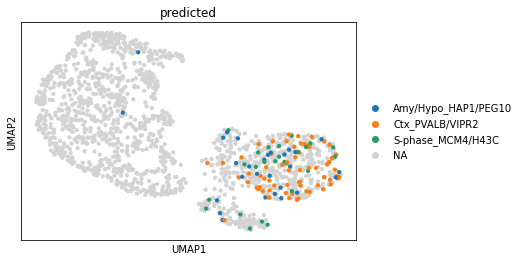

In [57]:
sc.pl.umap(mo_data, color='predicted')

In [2]:
import plotly.express as px 
import plotly.graph_objects as go

# first = pd.Series(le.inverse_transform(topk_td.loc[:, 0].values)).value_counts()
# # second = pd.Series(le.inverse_transform(topk_td.loc[:, 1].values)).value_counts()

# fig = go.Figure(
#     data=[
#         go.Bar(x=first.index, y=first.values, name='First Predicted Label'),
#     ]
# )

# fig.update_layout(
#     title='Distribution of Inferred Cell Types from Transplanted Cells (TDTomato Positive)',
#     font_family='Serif',
#     xaxis_title='Cell Type',
#     yaxis_title='Number of cells',
#     legend=None,
# )

# fig.show()
# fig.write_image('../../ms-thesis/images/mo_experiment_inference_td.pdf', scale=3)

In [1]:
# second = pd.Series(le.inverse_transform(topk_td.loc[:, 2].values)).value_counts()

# fig = go.Figure(
#     data=[
#         go.Bar(x=second.index, y=second.values, name='Second Predicted Label'),
#     ]
# )

# fig.update_layout(
#     title='Distribution of Inferred Cell Types from Transplanted Cells (TDTomato Positive)',
#     font_family='Serif',
#     xaxis_title='Cell Type',
#     yaxis_title='Number of cells',
#     legend=None,
# )

# fig.show()
# fig.write_image('../../ms-thesis/images/mo_experiment_inference_td_2.pdf', scale=3)

In [16]:
to_pred = np.asarray(mo_data[np.where(mo_data.X.todense()[:, -1] > 0)[0]].X.todense())
data = TestAnndatasetMatrix(to_pred)

loader = CollateLoader(
    dataset=data,
    refgenes=refgenes,
    currgenes=mo_genes,
    batch_size=4,
    num_workers=0,
)

explain_matrix = model.explain(loader)

100%|███████████████████████████████████████████████████████| 57/57 [00:04<00:00, 13.61it/s]


In [32]:
explain_matrix

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [])

In [148]:
from anndata import AnnData

adata = AnnData(
    explain_matrix[0],
    topk_td.loc[:, 0].values,
)

adata.obs['celltype'] = le.inverse_transform(adata.obs.loc[:, 0])
adata.var.index = refgenes

/var/folders/pd/jsjcl0fn7w57s5mfr34b20pm0000gn/T/ipykernel_89268/723343829.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
/Users/julian/miniconda3/envs/sims/lib/python3.9/site-packages/anndata/_core/anndata.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


In [149]:
vals = adata.obs['celltype'].value_counts()[-4:].index.to_list()
to_drop = np.where(adata.obs['celltype'].isin(vals))[0]

In [150]:
to_keep = [x for x in adata.obs.index if int(x) not in to_drop]

adata = adata[to_keep, :]

In [153]:
adata

View of AnnData object with n_obs × n_vars = 221 × 25163
    obs: 0, 'celltype'

In [154]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/Users/julian/miniconda3/envs/sims/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


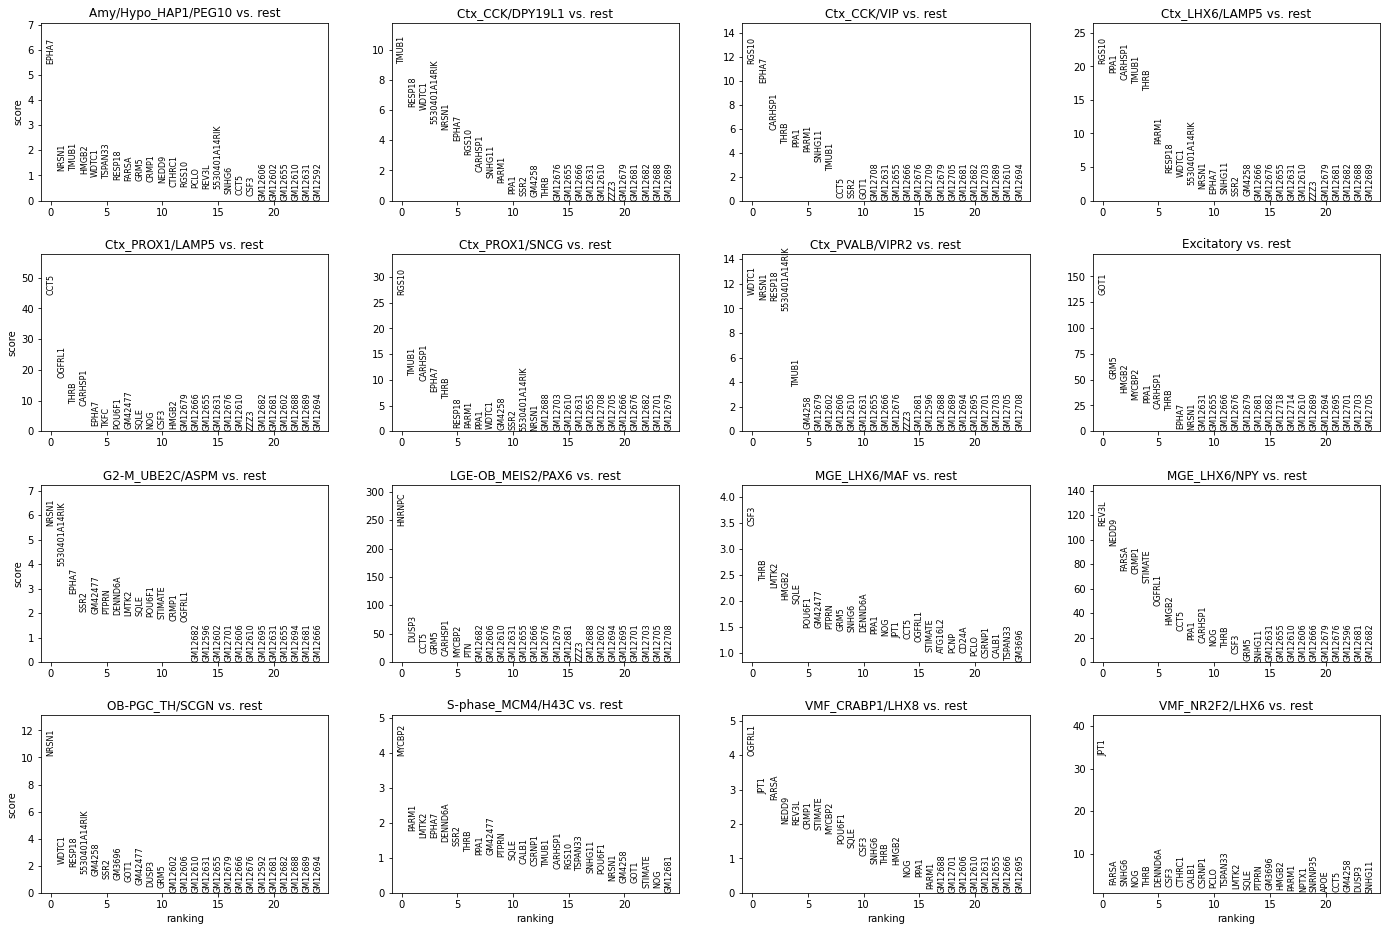

In [155]:
sc.tl.rank_genes_groups(adata, 'celltype', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

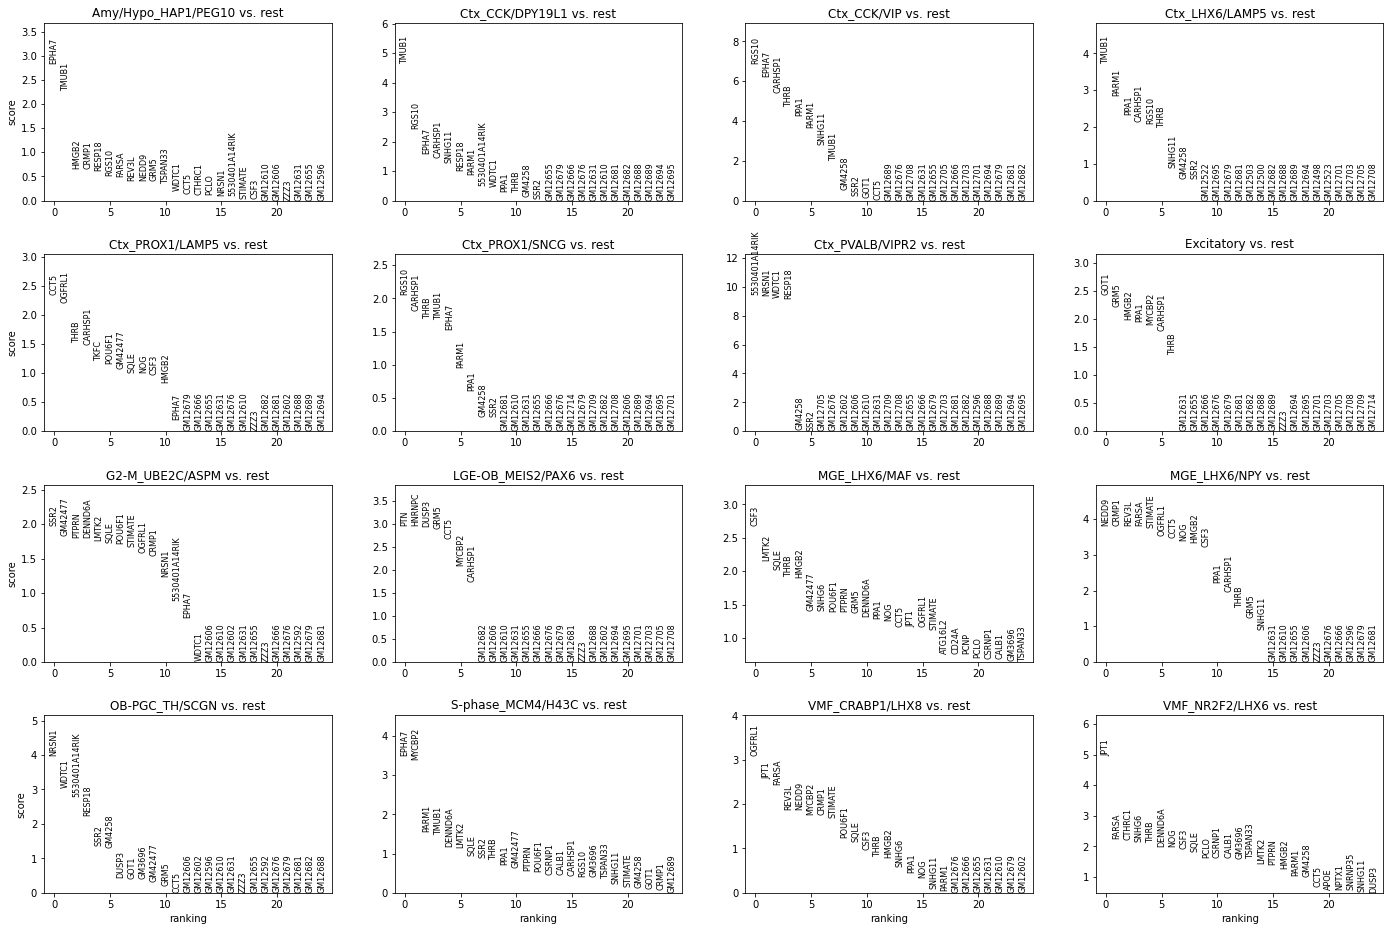

In [156]:
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

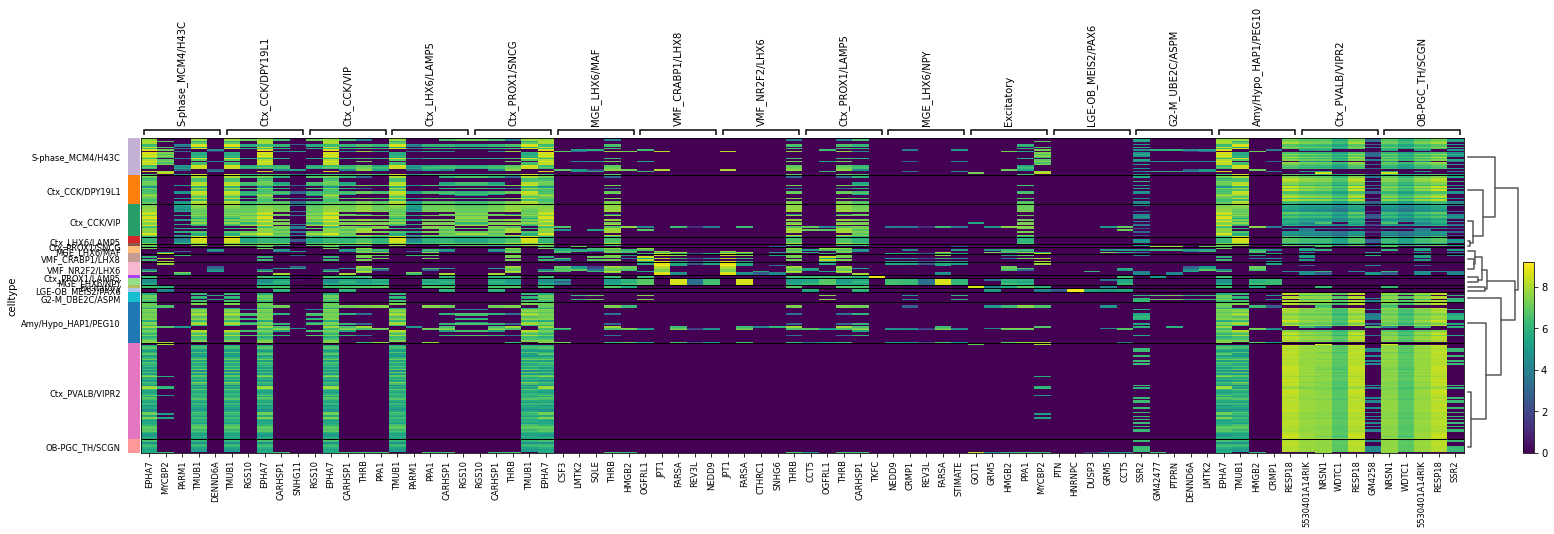

In [159]:
sc.pl.rank_genes_groups_heatmap(
    adata, 
    n_genes=5,
    key="wilcoxon", 
    groupby="celltype",
    show_gene_labels=True,
    save="mo_tdtomato_positive.pdf",
)

In [34]:
first = pd.Series(le.inverse_transform(topk_all.loc[:, 0].values)).value_counts()
second = pd.Series(le.inverse_transform(topk_all.loc[:, 1].values)).value_counts()

fig = go.Figure(
    data=[
        go.Bar(x=first.index, y=first.values, name='First Predicted Label'),
    ]
)

fig.update_layout(
    title='Distribution of Inferred Cell Types from Transplanted Cells (All)',
    font_family='Serif',
    xaxis_title='Cell Type',
    yaxis_title='Number of cells',
    legend=None,
)

fig.show()
fig.write_image('../../ms-thesis/images/mo_experiment_inference_all.pdf', scale=3)

Let's also visualize the training distribution to understand the differnces in cell type.

In [36]:
MGE_cluster = np.where(labels == 'MGE_LHX6/MAF')[0]

MGE_cluster

NameError: name 'labels' is not defined

In [37]:
second_confident = pd.Series(le.inverse_transform(topk.loc[MGE_cluster, 1]))

px.bar(second_confident.value_counts())

NameError: name 'topk' is not defined

In [38]:
second_confident = pd.Series(le.inverse_transform(topk.loc[MGE_cluster, 2]))

px.bar(second_confident.value_counts())

NameError: name 'topk' is not defined

# Model training with just PVALB and SST

In [ ]:
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl 

module = DataModule(
    datafiles=['../data/mouse/MouseAdultInhibitoryNeurons.h5ad'],
    labelfiles=['../data/mouse/pvalb_sst_labels.csv'],
    class_label='class',
    batch_size=32,
    num_workers=0,
    shuffle=True,
    drop_last=True,
    normalize=True,
    refgenes=refgenes,
    currgenes=atlas_genes,
    deterministic=True,
)

wandb_logger = WandbLogger(
    project=f"Mostajo Mouse Model, PVALB vs SST",
    name='Local',
)

lr_callback = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

upload_callback = UploadCallback(
    path='../checkpoints',
    desc='mostajo-mouse-5-23-22-pvalb-sst'
)

early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
)

trainer = pl.Trainer(
    gpus=(1 if torch.cuda.is_available() else 0),
    auto_lr_find=False,
    logger=wandb_logger,
    max_epochs=500,
    gradient_clip_val=0.5,
    callbacks=[
        lr_callback, 
        upload_callback,
        early_stopping_callback,
    ]
)

model = SIMSClassifier(
    input_dim=module.num_features,
    output_dim=module.num_labels,
)

trainer.fit(model, datamodule=module)

/Users/julian/miniconda3/envs/sims/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initializing network
Initializing explain matrix
Creating train/val/test DataLoaders...


In [40]:
pd.read_csv('../data/mouse/pvalb_sst_labels.csv')["class"].unique()

array(['Ctx_LHX6/SST', 'Ctx_LHX6/PVALB'], dtype=object)